In [1]:
import cv2
import numpy as np
import mediapipe as mp
import os 
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
def display_image(image):
    
    plt.figure(figsize = (8,8))
    plt.imshow(image)
    plt.title(f"Shape : {image.shape}")
    plt.axis("off")
    plt.show()

def convert_rgb(image):
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
class handDetector():
    
    def __init__(self,mode = False,maxHands = 2, modelComplexity = 1, detectionCon = 0.5,trackCon = 0.5):
        
        self.mode = mode
        self.maxHands = maxHands
        self.modelComplexity = modelComplexity
        self.detectionCon = detectionCon
        self.trackCon = trackCon
        
        self.mpHands = mp.solutions.hands 
        self.mpDraw = mp.solutions.drawing_utils
        
        self.hands = self.mpHands.Hands(self.mode,self.maxHands,self.modelComplexity,
                                         self.detectionCon, self.trackCon)
        
    def findHands(self,image,draw = True):
        
        imgRGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        self.results = self.hands.process(imgRGB)
        
        if self.results.multi_hand_landmarks:
            #myHand = self.results.multi_hand_landmarks[0]
            for handLms in self.results.multi_hand_landmarks:
                if draw:
                    self.mpDraw.draw_landmarks(image,handLms,self.mpHands.HAND_CONNECTIONS)
                    
        return image
    
    def findPosition(self,image,handNo = 0, draw = True):
        
        lmList = []
        if self.results.multi_hand_landmarks:
            myHand = self.results.multi_hand_landmarks[handNo]
            
            for id,lm in enumerate(myHand.landmark):
                h,w,c = image.shape
                cx,cy = int(lm.x*w),int(lm.y*h)
                lmList.append([id,cx,cy])
                
                if draw:
                    cv2.circle(image,(cx,cy),15,(255,0,255),cv2.FILLED)
                    
        return lmList

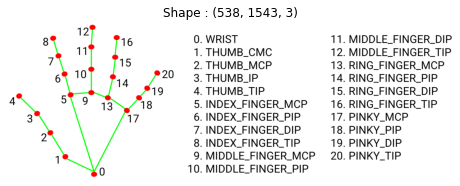

In [4]:
hands_path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/mediapipeHands.png"
display_image(convert_rgb(cv2.imread(hands_path)))

In [5]:
path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/Numbers"

cap = cv2.VideoCapture(0)
wCam,hCam = 640,480
cap.set(3,wCam)
cap.set(4,hCam)

myList = os.listdir(path)

if '.ipynb_checkpoints' in myList:
    myList.remove('.ipynb_checkpoints')

myList.sort()
overlayList = []
for imPath in myList:
    image = cv2.imread(f"{path}/{imPath}")
    image = cv2.resize(image,(200,200))
    overlayList.append(image)
    
#print(overlayList[0].shape)

cTime = 0
pTime = 0
    
detector = handDetector()

tipIds = [4, 8, 12, 16, 20]

# Sağ elde çalışır düzgün !!!

while True:

    conn, frame = cap.read()    
    frame = detector.findHands(frame)
    lmList = detector.findPosition(frame,draw = False)
    #print(np.array(lmList).shape)
    
    if len(lmList) != 0:
        fingers = []
        # Kameraya göre bak 
        # Soldan sağ uzaklık !!!
        if lmList[tipIds[0]][1] > lmList[tipIds[0] -1][1]:
            fingers.append(1)
        else:
            fingers.append(0)
         
        # Yukardan aşağı olduğu için zıttı gibi düşün !!!
        for id in range(1,5):
            # FOR 4 FINGERS !!!!!
            # Yukardaki resimden anlarsın !!
            # height göre hesaplama
            # Neden -2 olduğunu
            if lmList[tipIds[id]][2] < lmList[tipIds[id] - 2][2]:
                #print("Index Finger Open")
                fingers.append(1)
            else:
                fingers.append(0)
        
        #print(fingers)
        totalFingers = fingers.count(1)
        #print(totalFingers)
        if totalFingers == 0:
            h,w,c = overlayList[-1].shape
            frame[0:h,0:w] = overlayList[-1]
            
        else:
            
            h,w,c = overlayList[totalFingers-1].shape
            frame[0:h,0:w] = overlayList[totalFingers-1]
            
        cv2.rectangle(frame,(20,225),(170,425),(0,255,0),cv2.FILLED)
        cv2.putText(frame,str(totalFingers),(45,375),cv2.FONT_HERSHEY_PLAIN,10,(255,0,0),25)
    
    
    cTime = time.time()
    fps = 1 / (cTime-pTime)
    pTime = cTime
    
    cv2.putText(frame,f"FPS : {int(fps)}",(400,70),cv2.FONT_HERSHEY_PLAIN,3,(0,0,255),3)
    
    cv2.imshow("Image",frame)
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

cap.release()
cv2.destroyAllWindows()